In [8]:
from dataclasses import dataclass
from pathlib import Path

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
@dataclass(frozen=True)
class SCL:
    NO_DATA: int = 0
    SATURATED_OR_DEFECTIVE: int = 1
    DARK_AREA_PIXELS: int = 2
    CLOUD_SHADOWS: int = 3
    VEGETATION: int = 4
    NOT_VEGETATED: int = 5
    WATER: int = 6
    UNCLASSIFIED: int = 7
    CLOUD_MEDIUM_PROBABILITY: int = 8
    CLOUD_HIGH_PROBABILITY: int = 9
    THIN_CIRRUS: int = 10
    SNOW: int = 11

In [3]:
# Open the TIFF file
tiff_path = "/Users/Shared/Quantum/Projects/plot_boundary_detection/data/satellite_imagery/sentinel/uk_fields_5km/0022.tif"
tiff_path = "/Users/Shared/Quantum/Projects/plot_boundary_detection/data/satellite_imagery/planet/kharkiv_2016/tiles/20170501_074948_101f_3B_AnalyticMS_TCI_3m.tif"
with rasterio.open(tiff_path) as dataset:
    metadata = dataset.meta  # General metadata
    tags = dataset.tags()    # Additional metadata (may contain date)
    band_count = dataset.count
    band_info = dataset.descriptions
    
print("Metadata:", metadata)
print("Tags:", tags)
print(f"#Bands: {band_count}")
print(f"Band info: {band_info}")

Metadata: {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 9181, 'height': 4692, 'count': 3, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 36N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32636"]]'), 'transform': Affine(3.0, 0.0, 624693.0,
       0.0, -3.0, 5578560.0)}
Tags: {'AREA_OR_POINT': 'Area'}
#Bands: 3
Band info: (None, None, None)


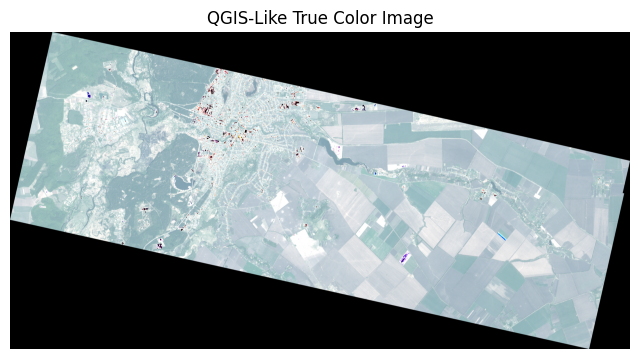

In [21]:
tiff_path = "/Users/Shared/Quantum/Projects/plot_boundary_detection/data/satellite_imagery/planet/kharkiv_2016/tiles/20170501_074948_101f_3B_AnalyticMS_TCI_3m.tif"

# Open the TIFF file and read correct bands
with rasterio.open(tiff_path) as dataset:
    red = dataset.read(1)
    green = dataset.read(2)
    blue = dataset.read(3)
    # red = dataset.read(6).astype(np.float32)   # Corrected: Red is Band 5
    # green = dataset.read(4).astype(np.float32) # Corrected: Green is Band 3
    # blue = dataset.read(2).astype(np.float32)  # Corrected: Blue is Band 2
    # nir = dataset.read(8)
    # nir08 = dataset.read(5)

# Function to apply percentile stretching (QGIS default is 2%-98%)
def stretch(image, lower_percent=2, upper_percent=98):
    """Perform contrast stretching similar to QGIS."""
    min_val = np.percentile(image, lower_percent)
    max_val = np.percentile(image, upper_percent)
    return np.clip((image - min_val) / (max_val - min_val), 0, 1)

# Apply stretching
red_stretched = stretch(red)
green_stretched = stretch(green)
blue_stretched = stretch(blue)

# Stack and display
rgb_image = np.dstack((red_stretched, green_stretched, blue_stretched))

plt.figure(figsize=(8, 8))
plt.imshow(rgb_image)
plt.axis("off")
plt.title("QGIS-Like True Color Image")
plt.show()

In [19]:
plt.imshow(nir)
plt.axis("off")
plt.show()

NameError: name 'nir' is not defined

In [12]:
# Open the TIFF file
with rasterio.open(tiff_path) as dataset:
    transform = dataset.transform  # Affine transform matrix
    crs = dataset.crs  # Coordinate Reference System
    print(f"Tiff CRS: {crs}")
    width = dataset.width  # Number of pixels in x-direction
    height = dataset.height  # Number of pixels in y-direction

    # Pixel size in x and y direction (in CRS units, typically meters)
    pixel_width = transform.a  # Usually positive
    pixel_height = -transform.e  # Usually negative, take absolute value

    # Calculate area
    pixel_area = pixel_width * pixel_height  # Area of one pixel
    total_area = pixel_area * width * height  # Total area

print(f"Total area covered: {total_area / 1_000_000:.2f} square kilometers")
print(f"Total area covered: {total_area:.2f} square meters")

Tiff CRS: EPSG:32637
Total area covered: 1276.30 square kilometers
Total area covered: 1276295508.00 square meters


In [6]:
with rasterio.open(tiff_path) as dataset:
    tags = dataset.tags()
    
    print(f"Date Found: {tags['DATE']}")

Date Found: 2021-05-31 11:16:20


In [7]:
values, counts = np.unique(scl, return_counts=True)

for val, count in zip(values, counts):
    print(f"{val}: {count}")

0.0: 4
2.0: 824
3.0: 856
4.0: 221718
5.0: 36150
7.0: 16866
8.0: 19763
9.0: 14068


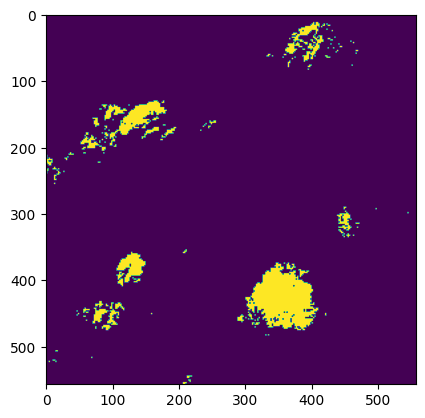

In [16]:
plt.imshow((scl==9).astype(np.uint8)*255)
plt.show()

# SCL filtering

In [10]:
tiles_dir = Path("/Users/Shared/Quantum/Projects/plot_boundary_detection/data/satellite_imagery/sentinel/france_fields_5km")
tile_list = list(tiles_dir.glob("*.tif"))

total_pixels = 0
bad_pixels = 0
medium_bad_pixels = 0

bad_scl = set([SCL.NO_DATA, SCL.CLOUD_HIGH_PROBABILITY, SCL.CLOUD_MEDIUM_PROBABILITY])
medium_bad_scl = set([SCL.NO_DATA, SCL.CLOUD_HIGH_PROBABILITY, SCL.CLOUD_MEDIUM_PROBABILITY, SCL.UNCLASSIFIED, SCL.DARK_AREA_PIXELS])

for tile_path in tqdm(tile_list):
    with rasterio.open(tile_path) as dataset:
        scl = dataset.read(7)
    
    for x in bad_scl:
        bad_pixels += np.sum(scl == x)
    for x in medium_bad_scl:
        medium_bad_pixels += np.sum(scl == x)

    total_pixels += scl.shape[0] * scl.shape[1]

print(f"#Bad pixel ratio: {round(bad_pixels / total_pixels * 100, 10)}%")
print(f"#Medium bad pixel ratio: {round(medium_bad_pixels / total_pixels * 100, 10)}%")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1662/1662 [00:15<00:00, 107.45it/s]

#Bad pixel ratio: 14.329099247%
#Medium bad pixel ratio: 25.0943953336%


In [14]:
shape = (256, 256)
print(f"#tiles of shape {shape} (approximate): {round(total_pixels / shape[0] / shape[1])}")
print(f"Counting for bad pixels: {round((total_pixels - medium_bad_pixels) / shape[0] / shape[1])}")

#tiles of shape (256, 256) (approximate): 4567
Counting for bad pixels: 3768
